<h1> Import and data exploration

In [1]:
# declare all library
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns

In [2]:
# import the three datasets
df_data_1 = pd.read_csv('HR_comma_sep.csv')
df_data_2 = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df_data_3 = pd.read_csv('turnover.csv', encoding = 'ISO-8859-1')
df_model_1 = df_data_1.copy()
df_model_2 = df_data_2.copy()
df_model_3 = df_data_3.copy()

In [3]:
# check for null.
display(df_data_1.isnull().values.any())
display(df_data_2.isnull().values.any())
display(df_data_3.isnull().values.any())

False

False

False

<h1> Data preprocessing

In [4]:
# declare all column that will be removed.
drop2 = ['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18']
# drop column will get erased.
df_model_2 = df_model_2.drop(drop2,axis=1)

In [5]:
# rename all the target column.
df_model_1 = df_model_1.rename(columns={'left': 'churn'})
df_model_2 = df_model_2.rename(columns={'Attrition': 'churn'})
df_model_3 = df_model_3.rename(columns={'event': 'churn'})

# rename all the treatment column.
df_model_1 = df_model_1.rename(columns={'promotion_last_5years': 'treatment'})
df_model_2 = df_model_2.rename(columns={'OverTime': 'treatment'})
df_model_3 = df_model_3.rename(columns={'coach': 'treatment'})

In [6]:
# declare all string column for label encoding.
string1, string2, string3 = ['salary'], ['churn',
                                         'treatment',
                                         'BusinessTravel'], ['treatment']
# explore the unique data
for col in string1:
    display(col, df_model_1[col].unique())
for col in string2:
    display(col, df_model_2[col].unique())
for col in string3:
    display(col, df_model_3[col].unique())

'salary'

array(['low', 'medium', 'high'], dtype=object)

'churn'

array(['Yes', 'No'], dtype=object)

'treatment'

array(['Yes', 'No'], dtype=object)

'BusinessTravel'

array(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], dtype=object)

'treatment'

array(['no', 'yes', 'my head'], dtype=object)

In [7]:
# label encoding the target and treatment in dataset 1
df_model_1.salary = df_model_1.salary.map({'low': 0, 'medium': 1, 'high':2})

In [8]:
# label encoding the target and treatment in dataset 2
df_model_2.churn = df_model_2.churn.map({'Yes': 1, 'No': 0})
df_model_2.treatment = df_model_2.treatment.map({'Yes': 0, 'No': 1})
# Declaration BusinessTravel
df_model_2.BusinessTravel = df_model_2.BusinessTravel.map({'Non-Travel': 0,
                                                           'Travel_Rarely': 1,
                                                           'Travel_Frequently':2})

In [9]:
# label encoding the target and treatment in dataset 3
df_model_3.treatment = df_model_3.treatment.map({'yes': 0, 'no': 1, 'my head':2})
df_model_3 = df_model_3.loc[df_model_3.treatment <=1].reset_index(drop=True)

In [10]:
# One-Hot Encoding for all three datasets :
df_model_1, df_model_inverse_1 = pd.get_dummies(df_model_1), pd.get_dummies(df_model_1)
df_model_2, df_model_inverse_2 = pd.get_dummies(df_model_2), pd.get_dummies(df_model_2)
df_model_3, df_model_inverse_3 = pd.get_dummies(df_model_3), pd.get_dummies(df_model_3)

In [11]:
# calculating treatment correlation
def correlation_treatment(df:pd.DataFrame):
    correlation = df[['treatment','churn']].corr(method ='pearson') 
    return(pd.DataFrame(round(correlation.loc['churn'] * 100,2)))

In [12]:
print("Dataset 1:", correlation_treatment(df_model_1).iloc[0,0])
print("Dataset 2:", correlation_treatment(df_model_2).iloc[0,0])
print("Dataset 3:", correlation_treatment(df_model_3).iloc[0,0])

Dataset 1: -6.18
Dataset 2: -24.61
Dataset 3: -4.0


In [13]:
# function for add the four target classes
def declare_target_class(df:pd.DataFrame):
    """function for declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.churn == 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment == 1) & (df.churn == 1),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment == 1) & (df.churn == 0),'target_class'] = 3 
    return df

In [14]:
# Add the target class for the three datasets
df_model_1, df_model_2, df_model_3 = declare_target_class(df_model_1), \
declare_target_class(df_model_2), declare_target_class(df_model_3)

<h1> Machine Learning

In [15]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
def split_data(df_model:pd.DataFrame):
    """Split data into data train and data test
    """
    X = df_model.drop(['churn','target_class'],axis=1)
    y = df_model.churn
    z = df_model.target_class
    X_train, X_test, \
    y_train, y_test, \
    z_train, z_test = train_test_split(X,
                                       y,
                                       z,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test, z_train, z_test


def machine_learning(X_train:pd.DataFrame,
                     X_test:pd.DataFrame,
                     y_train:pd.DataFrame,
                     y_test:pd.DataFrame,
                     z_train:pd.DataFrame,
                     z_test:pd.DataFrame):
    """machine learning process with XGB Algorithm
    """
    # Prepare a new Dataframe prediction result
    prediction_results = pd.DataFrame(X_test).copy()
    
    
    # Train Model CP Process
    model_tp \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)  
    # ETP model Prediction Process
    prediksi_tp \
    = model_tp.predict(X_test.drop('treatment',axis=1))
    probabilitas_tp \
    = model_tp.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediksi_churn'] = prediksi_tp
    prediction_results['proba_churn'] = probabilitas_tp[:,1]
    
    
    # Train Model Uplift Process 
    model_etu \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), z_train)
    # ETU model Prediction Process
    prediksi_etu \
    = model_etu.predict(X_test.drop('treatment', axis=1))
    probabilitas_etu \
    = model_etu.predict_proba(X_test.drop('treatment', axis=1))
    prediction_results['prediksi_target_class'] = prediksi_etu
    prediction_results['proba_CN'] = probabilitas_etu[:,0] 
    prediction_results['proba_CR'] = probabilitas_etu[:,1] 
    prediction_results['proba_TN'] = probabilitas_etu[:,2] 
    prediction_results['proba_TR'] = probabilitas_etu[:,3]
    prediction_results['skor_etu'] = prediction_results.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    
    # input a validation churn and a target class to dataframe
    prediction_results['churn'] = y_test
    prediction_results['target_class'] = z_test
    return prediction_results


def predict(df_model:pd.DataFrame):
    """Combining data split and machine learning modeling
    """
    X_train, X_test, y_train, y_test, z_train, z_test = split_data(df_model)
    prediction_results = machine_learning(X_train,
                                          X_test,
                                          y_train,
                                          y_test,
                                          z_train,
                                          z_test)
    return prediction_results

In [16]:
# Machine Learning Modelling Process
prediction_results_1 = predict(df_model_1)
prediction_results_2 = predict(df_model_2)
prediction_results_3 = predict(df_model_3)

<h1> Evaluating predictive performance

In [17]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
def cm_evaluation(df:pd.DataFrame):
    """Confusion matrix evaluation
    """  
    print("1. ETP's confusion matrix result:")
    confusion_etp = confusion_matrix(df['churn'], df['prediksi_churn'])
    df_confusion_etp = pd.DataFrame(confusion_etp, columns = ['True','False'], index = ['Positive','Negative'])
    display(df_confusion_etp)
    
    
    print("2. ETU's confusion matrix result:")   
    confusion_etu = multilabel_confusion_matrix(df['target_class'], df['prediksi_target_class'])
    print("a. CN's confusion matrix:")  
    df_cn = pd.DataFrame(confusion_etu[0], columns = ['True','False'], index = ['Positive','Negative'])
    display(df_cn)
    print("b. CR's confusion matrix:") 
    df_cr = pd.DataFrame(confusion_etu[1], columns = ['True','False'], index = ['Positive','Negative'])
    display(df_cr) 
    print("c. TN's confusion matrix:")
    df_tn = pd.DataFrame(confusion_etu[2], columns = ['True','False'], index = ['Positive','Negative'])
    display(df_tn) 
    print("d. TR's confusion matrix:") 
    df_tr = pd.DataFrame(confusion_etu[3], columns = ['True','False'], index = ['Positive','Negative'])
    display(df_tr)  

In [18]:
# Accuracy Evaluation Process
print("Dataset 1")
cm_evaluation(prediction_results_1)
print("Dataset 2")
cm_evaluation(prediction_results_2)
print("Dataset 3")
cm_evaluation(prediction_results_3)

Dataset 1
1. ETP's confusion matrix result:


,True,False
Positive,3392,44
Negative,83,981


2. ETU's confusion matrix result:
a. CN's confusion matrix:


,True,False
Positive,3390,53
Negative,81,976


b. CR's confusion matrix:


,True,False
Positive,991,162
Negative,49,3298


c. TN's confusion matrix:


,True,False
Positive,4493,0
Negative,7,0


d. TR's confusion matrix:


,True,False
Positive,4408,3
Negative,81,8


Dataset 2
1. ETP's confusion matrix result:


,True,False
Positive,374,4
Negative,52,11


2. ETU's confusion matrix result:
a. CN's confusion matrix:


,True,False
Positive,406,6
Negative,29,0


b. CR's confusion matrix:


,True,False
Positive,331,14
Negative,95,1


c. TN's confusion matrix:


,True,False
Positive,406,1
Negative,33,1


d. TR's confusion matrix:


,True,False
Positive,9,150
Negative,14,268


Dataset 3
1. ETP's confusion matrix result:


,True,False
Positive,76,48
Negative,49,72


2. ETU's confusion matrix result:
a. CN's confusion matrix:


,True,False
Positive,219,3
Negative,19,4


b. CR's confusion matrix:


,True,False
Positive,226,2
Negative,15,2


c. TN's confusion matrix:


,True,False
Positive,95,52
Negative,37,61


d. TR's confusion matrix:


,True,False
Positive,82,56
Negative,42,65


In [19]:
from sklearn.metrics import accuracy_score
def accuracy_evaluation(df:pd.DataFrame):
    """Accuracy evaluation
    """
    akurasi_cp = accuracy_score(df['churn'],
                                df['prediksi_churn'])
    print('ETP model accuracy: %.2f%%' % (akurasi_cp * 100.0))
    
    
    akurasi_uplift = accuracy_score(df['target_class'],
                                    df['prediksi_target_class'])
    print('ETU model accuracy: %.2f%%' % (akurasi_uplift * 100.0))

In [20]:
# Accuracy Evaluation Process
print("Dataset 1")
accuracy_evaluation(prediction_results_1)
print("Dataset 2")
accuracy_evaluation(prediction_results_2)
print("Dataset 3")
accuracy_evaluation(prediction_results_3)

Dataset 1
ETP model accuracy: 97.18%
ETU model accuracy: 95.16%
Dataset 2
ETP model accuracy: 87.30%
ETU model accuracy: 61.22%
Dataset 3
ETP model accuracy: 60.41%
ETU model accuracy: 53.88%


<h1> Evaluating rescriptive performance

In [21]:
def sorting_data(df:pd.DataFrame):
    """Function to sort data
    """
    # Set up new dataframe for CP and ETU models
    df_c = pd.DataFrame({'n':[], 'target_class':[]})
    df_u = df_c.copy()
    df_c['target_class'] = df['target_class']
    df_u['target_class'] = df['target_class']
    
    
    # Add a quantile sequence
    df_c['n'] = df.proba_churn.rank(pct=True, ascending=False)
    df_u['n'] = df.skor_etu.rank(pct=True, ascending=False)
    df_c['skor'] = df['proba_churn']
    df_u['skor'] = df['skor_etu']
    
    
    # Data sorting process    
    df_c = df_c.sort_values(by='n').reset_index(drop=True)
    df_u = df_u.sort_values(by='n').reset_index(drop=True)
    df_c['model'], df_u['model'] = 'CP', 'Uplift'
    return df_c, df_u


def calculating_qini(df:pd.DataFrame):
    """Function to measure the Qini value
    """
    # Variabel control group dan treatment group
    C, T = sum(df['target_class'] <= 1), sum(df['target_class'] >= 2)
    df['cr'] = 0
    df['tr'] = 0
    df.loc[df.target_class  == 1,'cr'] = 1
    df.loc[df.target_class  == 3,'tr'] = 1
    df['cr/c'] = df.cr.cumsum() / C
    df['tr/t'] = df.tr.cumsum() / T
    
    
    # Calculate & Inserting qini value into Dataframe
    df['uplift'] = df['tr/t'] - df['cr/c']
    df['random'] = df['n'] * df['uplift'].iloc[-1]
    # Add q0 to your Dataframe
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    qini = pd.concat([q0, df]).reset_index(drop = True)
    return qini


def merging_data(df_c:pd.DataFrame, df_u:pd.DataFrame):
    """Function to add the 'Model' column and merge the dataframe into one
    """
    df_u['model'] = 'ETU'
    df_c['model'] = 'ETP'
    df = pd.concat([df_u, df_c]).sort_values(by='n').reset_index(drop = True)
    return df


def plot_qini(df:pd.DataFrame):
    """Function to plot qini
    """
    # Define the data to be visualized
    order = ['ETU','ETP']
    ax = sns.lineplot(x='n', y=df.uplift, hue='model', data=df,
                      style='model', palette=['red','deepskyblue'],
                      style_order=order, hue_order = order)
    
    
    # Plot display settings
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=30)
    plt.ylabel('Uplift',fontsize=30)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=30)
    ax.tick_params(labelsize=24)
    ax.legend(handles=handles[1:], labels=labels[1:])
    ax.plot([0,1], [0,df.loc[len(df) - 1,'uplift']],'--', color='grey')
    return ax


def evaluation_qini(prediction_results:pd.DataFrame):
    """Function to combine all qini evaluation processes
    """
    df_c, df_u = sorting_data(prediction_results)
    qini_c, qini_u = calculating_qini(df_c), calculating_qini(df_u)
    qini = merging_data(qini_c, qini_u)
    ax = plot_qini(qini)
    return ax, qini

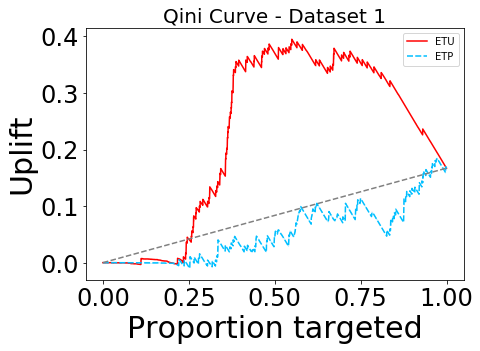

In [22]:
# qini evaluation results for DataSet 1 with negative treatment correlation
ax, qini_1 = evaluation_qini(prediction_results_1)
plt.title('Qini Curve - Dataset 1',fontsize=20)
plt.savefig('qini_1_n.pdf', bbox_inches='tight')

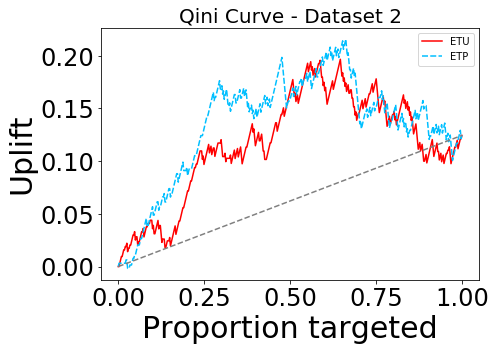

In [23]:
# qini evaluation results for DataSet 2 with negative treatment correlation
ax, qini_2 = evaluation_qini(prediction_results_2)
plt.title('Qini Curve - Dataset 2',fontsize=20)
plt.savefig('qini_2_n.pdf', bbox_inches='tight')

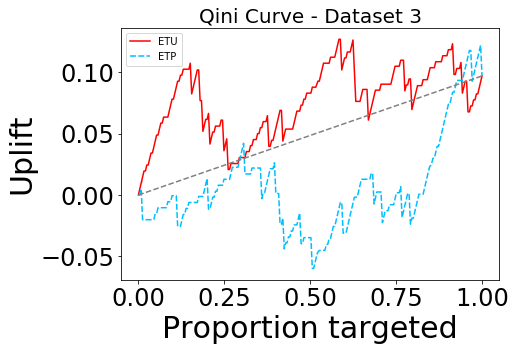

In [24]:
# qini evaluation results for DataSet 3 with negative treatment correlation
ax, qini_3 = evaluation_qini(prediction_results_3)
plt.title('Qini Curve - Dataset 3',fontsize=20)
plt.savefig('qini_3_n.pdf', bbox_inches='tight')

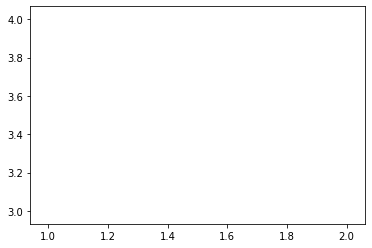

In [25]:
# Setting up the box and triangle shapes for the Swarmplot
fig, ax = plt.subplots(1,1)
a = ax.scatter([1,2],[3,4], marker='s')
b = ax.scatter([1,2],[3,4], marker='^')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()
def target_class_distribution(df_1:pd.DataFrame,
                            df_2:pd.DataFrame,
                            df_3:pd.DataFrame,
                            target_class:str):
    """Function to visualize the target class with Swarmplot"""
    
    
    # Add 'dataset' column
    df_1['dataset'] = 'Dataset 1'
    df_2['dataset'] = 'Dataset 2'
    df_3['dataset'] = 'Dataset 3'
    # Merge and sort all three datasets
    df = pd.concat([df_1, df_2, df_3])
    df = df.sort_values(by='n')[:round(len(df)/4)]
    
    
    # Set up the Swarmplot
    ax = sns.swarmplot(data=df[df.target_class==target_class],
                       x='dataset',
                       y='n',
                       hue='model',
                       palette=['deepskyblue','red'],
                       hue_order=['ETP', 'ETU'],
                       order=['Dataset 1', 'Dataset 2', 'Dataset 3'], size=6.5)
    
    
    collections = ax.collections
    unique_colors = np.unique(collections[0].get_facecolors(),axis=0)
    markers = [square_mk, triangle_up_mk]
    for collection in collections:
        paths = []
        for current_color in collection.get_facecolors():
            for possible_marker,possible_color in zip(markers, unique_colors):
                if np.array_equal(current_color,possible_color):
                    paths.append(possible_marker)
                    break
        collection.set_paths(paths)
        
    
    # Add swarmplot display settings
    ax.tick_params(labelsize=24)   
    ax.legend(collections[-2:],pd.unique(df.model))  
    plt.ylabel('Decile',fontsize=20)
    plt.xlabel('')
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=20)
    return ax

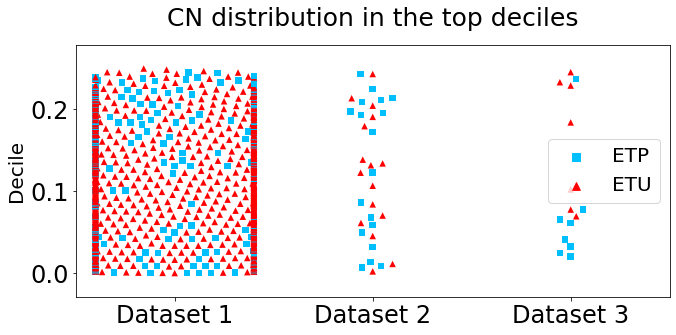

In [26]:
# Visualize CN in the top diciles with negative treatment correlation
target_class_distribution(qini_1, qini_2, qini_3, 0)
plt.title('CN distribution in the top deciles',fontsize=25, y=1.05)
plt.savefig('CN_n.pdf', bbox_inches='tight')

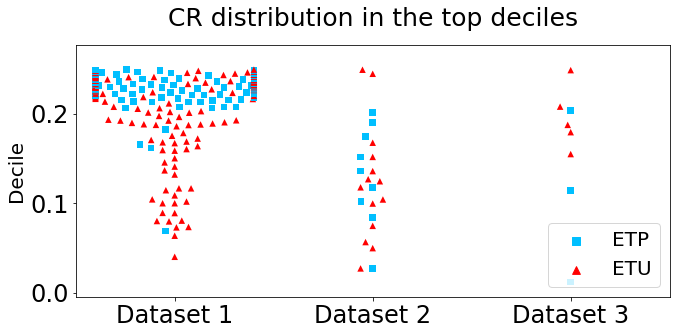

In [27]:
# Visualize CR in the top diciles with negative treatment correlation
target_class_distribution(qini_1, qini_2, qini_3, 1)
plt.title('CR distribution in the top deciles',fontsize=25, y=1.05)
plt.savefig('CR_n.pdf', bbox_inches='tight')

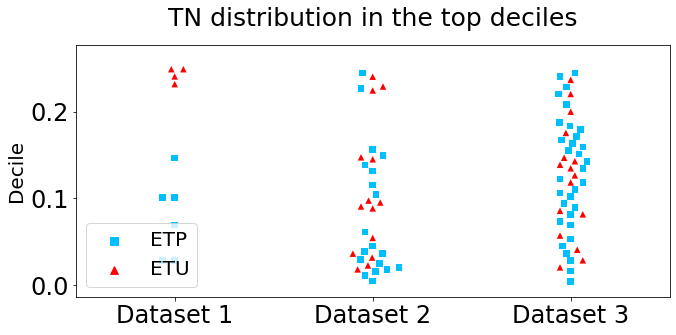

In [28]:
# Visualize TN in the top diciles with negative treatment correlation
target_class_distribution(qini_1, qini_2, qini_3, 2)
plt.title('TN distribution in the top deciles',fontsize=25, y=1.05)
plt.savefig('TN_n.pdf', bbox_inches='tight')

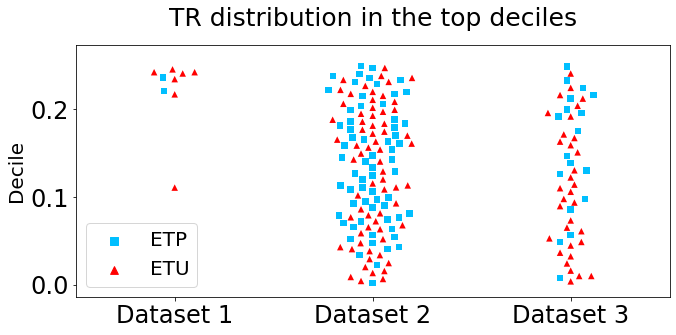

In [29]:
# Visualize TR in the top diciles with negative treatment correlation
target_class_distribution(qini_1, qini_2, qini_3, 3)
plt.title('TR distribution in the top deciles',fontsize=25, y=1.05)
plt.savefig('TR_n.pdf', bbox_inches='tight')

In [30]:
# The process of inverse treatment
df_model_inverse_1.treatment = df_model_inverse_1.treatment.replace({0: 1, 1: 0})
df_model_inverse_2.treatment = df_model_inverse_2.treatment.replace({0: 1, 1: 0})
df_model_inverse_3.treatment = df_model_inverse_3.treatment.replace({0: 1, 1: 0})

In [31]:
# Recalculate the treatment correlation
display(correlation_treatment(df_model_inverse_1).iloc[0,0])
display(correlation_treatment(df_model_inverse_2).iloc[0,0])
display(correlation_treatment(df_model_inverse_3).iloc[0,0])

6.18

24.61

4.0

In [32]:
# Add a feature target class to all three datasets
df_model_inverse_1, df_model_inverse_2, df_model_inverse_3 = declare_target_class(df_model_inverse_1), \
declare_target_class(df_model_inverse_2), declare_target_class(df_model_inverse_3)

In [33]:
# Machine Learning Modelling Process
prediction_results_inverse_1 = model_machine_learning(df_model_inverse_1)
prediction_results_inverse_2 = model_machine_learning(df_model_inverse_2)
prediction_results_inverse_3 = model_machine_learning(df_model_inverse_3)

NameError: name 'model_machine_learning' is not defined

In [ ]:
# qini evaluation results for DataSet 1 with positive treatment correlation
ax, qini_inverse_1 = evaluation_qini(prediction_results_inverse_1)
plt.title('Qini Curve - Dataset 1',fontsize=20)
plt.savefig('qini_1_p.pdf', bbox_inches='tight')

In [ ]:
# qini evaluation results for DataSet 2 with positive treatment correlation
ax, qini_inverse_2 = evaluation_qini(prediction_results_inverse_2)
plt.title('Qini Curve - Dataset 2',fontsize=20)
plt.savefig('qini_2_p.pdf', bbox_inches='tight')

In [ ]:
# qini evaluation results for DataSet 3 with positive treatment correlation
ax, qini_inverse_3 = evaluation_qini(prediction_results_inverse_3)
plt.title('Qini Curve - Dataset 3',fontsize=20)
plt.savefig('qini_3_p.pdf', bbox_inches='tight')

In [ ]:
# Visualize CN in the top diciles with positive treatment correlation
target_class_distribution(qini_inverse_1, qini_inverse_2, qini_inverse_3, 0)
plt.title('CN distribution in the top deciles',fontsize=25, y=1.05)
plt.savefig('CN_p.pdf', bbox_inches='tight')

In [ ]:
# Visualize CR in the top diciles with positive treatment correlation
target_class_distribution(qini_inverse_1, qini_inverse_2, qini_inverse_3, 1)
plt.title('CR distribution in the top deciles',fontsize=25, y=1.05)
plt.savefig('CR_p.pdf', bbox_inches='tight')

In [ ]:
# Visualize TN in the top diciles with positive treatment correlation
target_class_distribution(qini_inverse_1, qini_inverse_2, qini_inverse_3, 2)
plt.title('TN distribution in the top deciles',fontsize=25, y=1.05)
plt.savefig('TN_p.pdf', bbox_inches='tight')

In [ ]:
# Visualize TR in the top diciles with positive treatment correlation
target_class_distribution(qini_inverse_1, qini_inverse_2, qini_inverse_3, 3)
plt.title('TR distribution in the top deciles',fontsize=25, y=1.05)
plt.savefig('TR_p.pdf', bbox_inches='tight')